# MLP Classification with MR Dataset
<hr>

We will build a text classification model using MLP model on the Movie Reviews Dataset. Since there is no standard train/test split for this dataset, we will use 10-Fold Cross Validation (CV). 

## Load the library

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
from nltk.corpus import stopwords, twitter_samples
# from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import KFold
from nltk.stem import PorterStemmer
from string import punctuation
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
import time

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False
# nltk.download('twitter_samples')

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load the Dataset

In [3]:
corpus = pd.read_pickle('../../0_data/MR/MR.pkl')
corpus.label = corpus.label.astype(int)
print(corpus.shape)
corpus

(10662, 3)


,sentence,label,split
0,"simplistic , silly and tedious .",0,train
1,"it 's so laddish and juvenile , only teenage b...",0,train
2,exploitative and largely devoid of the depth o...,0,train
3,garbus discards the potential for pathological...,0,train
4,a visually flashy but narratively opaque and e...,0,train
...,...,...,...
10657,both exuberantly romantic and serenely melanch...,1,train
10658,mazel tov to a film about a family 's joyous l...,1,train
10659,standing in the shadows of motown is the best ...,1,train
10660,it 's nice to see piscopo again after all thes...,1,train


In [4]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10662 entries, 0 to 10661
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  10662 non-null  object
 1   label     10662 non-null  int32 
 2   split     10662 non-null  object
dtypes: int32(1), object(2)
memory usage: 208.4+ KB


In [5]:
corpus.groupby( by='label').count()

,sentence,split
label,,
0,5331,5331
1,5331,5331


In [6]:
# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

## Raw Number of Vocabulary

In [7]:
# Build the raw vocobulary for first inspection
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_raw = tokenizer.word_index
print('\nThe vocabulary size: {}\n'.format(len(vocab_raw)))
print(vocab_raw)


The vocabulary size: 18758

{'the': 1, 'a': 2, 'and': 3, 'of': 4, 'to': 5, 'is': 6, "'s": 7, 'it': 8, 'in': 9, 'that': 10, 'as': 11, 'but': 12, 'film': 13, 'with': 14, 'for': 15, 'this': 16, 'movie': 17, 'its': 18, 'an': 19, 'you': 20, 'be': 21, "n't": 22, 'on': 23, 'not': 24, 'by': 25, 'one': 26, 'like': 27, 'are': 28, 'about': 29, 'has': 30, 'more': 31, 'at': 32, 'than': 33, 'from': 34, 'all': 35, 'have': 36, 'his': 37, 'so': 38, 'if': 39, 'i': 40, 'or': 41, 'story': 42, 'too': 43, 'what': 44, 'there': 45, 'out': 46, 'who': 47, 'just': 48, 'up': 49, 'good': 50, 'into': 51, 'does': 52, 'most': 53, 'no': 54, 'much': 55, 'even': 56, 'comedy': 57, 'time': 58, 'will': 59, 'can': 60, 'some': 61, 'well': 62, 'characters': 63, 'he': 64, 'director': 65, 'only': 66, 'little': 67, 'way': 68, 'do': 69, 'funny': 70, 'their': 71, 'make': 72, 'been': 73, 'they': 74, 'your': 75, 'enough': 76, 'very': 77, 'we': 78, 'never': 79, 'when': 80, 'life': 81, 'makes': 82, 'would': 83, 'bad': 84, 'may': 85, 

<!--## Split Dataset-->

# Data Preprocessing
<hr>

## Define `clean_doc` function

In [8]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

## Develop Vocabulary

A part of preparing text for text classification involves defining and tailoring the vocabulary of words supported by the model. **We can do this by loading all of the documents in the dataset and building a set of words.**

The larger the vocabulary, the more sparse the representation of each word or document. So, we may decide to support all of these words, or perhaps discard some. The final chosen vocabulary can then be saved to a file for later use, such as filtering words in new documents in the future.

We can use `Counter` class and create an instance called `vocab` as follows:

In [9]:
from collections import Counter

vocab = Counter()

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab

In [10]:
# Example
add_doc_to_vocab(sentences, vocab)
print(len(vocab))
vocab

12666


Counter({'simplist': 19,
         'silli': 84,
         'tediou': 33,
         'laddish': 1,
         'juvenil': 7,
         'teenag': 25,
         'boy': 72,
         'could': 222,
         'possibl': 65,
         'find': 144,
         'funni': 295,
         'exploit': 39,
         'larg': 49,
         'devoid': 18,
         'depth': 41,
         'sophist': 28,
         'would': 251,
         'make': 618,
         'watch': 227,
         'graphic': 15,
         'treatment': 19,
         'crime': 60,
         'bearabl': 2,
         'garbu': 1,
         'discard': 3,
         'potenti': 40,
         'patholog': 7,
         'studi': 63,
         'exhum': 1,
         'instead': 71,
         'skew': 3,
         'melodrama': 53,
         'circumstanti': 2,
         'situat': 49,
         'visual': 129,
         'flashi': 12,
         'narr': 73,
         'opaqu': 6,
         'emot': 167,
         'vapid': 8,
         'exercis': 54,
         'style': 100,
         'mystif': 1,
         'stori

In [11]:
vocab.items()

dict_items([('simplist', 19), ('silli', 84), ('tediou', 33), ('laddish', 1), ('juvenil', 7), ('teenag', 25), ('boy', 72), ('could', 222), ('possibl', 65), ('find', 144), ('funni', 295), ('exploit', 39), ('larg', 49), ('devoid', 18), ('depth', 41), ('sophist', 28), ('would', 251), ('make', 618), ('watch', 227), ('graphic', 15), ('treatment', 19), ('crime', 60), ('bearabl', 2), ('garbu', 1), ('discard', 3), ('potenti', 40), ('patholog', 7), ('studi', 63), ('exhum', 1), ('instead', 71), ('skew', 3), ('melodrama', 53), ('circumstanti', 2), ('situat', 49), ('visual', 129), ('flashi', 12), ('narr', 73), ('opaqu', 6), ('emot', 167), ('vapid', 8), ('exercis', 54), ('style', 100), ('mystif', 1), ('stori', 540), ('also', 153), ('unorigin', 9), ('come', 285), ('alreadi', 44), ('recycl', 17), ('time', 504), ('care', 104), ('count', 21), ('thing', 241), ('give', 197), ('movi', 1602), ('point', 126), ('bravado', 3), ('take', 251), ('entir', 68), ('stale', 19), ('concept', 45), ('push', 21), ('audien

In [12]:
# #########################
# # Define the vocabulary #
# #########################

# from collections import Counter
# from nltk.corpus import stopwords
# stopwords = stopwords.words('english')
# stemmer = PorterStemmer()
    
# def clean_doc(doc):
#     # split into tokens by white space
#     tokens = doc.split()
#     # prepare regex for char filtering
#     re_punc = re.compile('[%s]' % re.escape(punctuation))
#     # remove punctuation from each word
#     tokens = [re_punc.sub('', w) for w in tokens]
#     # filter out stop words
#     tokens = [w for w in tokens if not w in stopwords]
#     # filter out short tokens
#     tokens = [word for word in tokens if len(word) >= 1]
#     # Stem the token
#     tokens = [stemmer.stem(token) for token in tokens]
#     return tokens

# def add_doc_to_vocab(docs, vocab):
#     '''
#     input:
#         docs: a list of sentences (docs)
#         vocab: a vocabulary dictionary
#     output:
#         return an updated vocabulary
#     '''
#     for doc in docs:
#         tokens = clean_doc(doc)
#         vocab.update(tokens)
#     return vocab
        

# # prepare cross validation with 10 splits and shuffle = True
# kfold = KFold(10, True)

# # Separate the sentences and the labels
# sentences, labels = list(corpus.sentence), list(corpus.label)

# acc_list = []

# # kfold.split() will return set indices for each split
# for train, test in kfold.split(sentences):
#     # Instantiate a vocab object
#     vocab = Counter()
    
#     train_x, test_x = [], []
#     train_y, test_y = [], []
    
#     for i in train:
#         train_x.append(sentences[i])
#         train_y.append(labels[i])
    
#     for i in test:
#         test_x.append(sentences[i])
#         test_y.append(labels[i])
    
#     vocab = add_doc_to_vocab(train_x, vocab)
#     print(len(train_x), len(test_x))
#     print(len(vocab))

<dir>

# Bag-of-Words Representation
<hr>

Once we define our vocab obtained from the training data, we need to **convert each review into a representation that we can feed to a Multilayer Perceptron Model.**

As a reminder, here are the summary what we will do:
- extract features from the text so the text input can be used with ML algorithms like neural networks
- we do by converting the text into a vector representation. The larger the vocab, the longer the representation.
- we will score the words in a document inside the vector. These scores are placed in the corresponding location in the vector representation.

In [13]:
def doc_to_line(doc):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join([token for token in tokens])
    return line

In [14]:
def clean_docs(docs):
    lines = []
    for doc in docs:
        line = doc_to_line(doc)
        lines.append(line)
    return lines

In [15]:
print(sentences[:5])
clean_sentences = clean_docs(sentences[:5])
print()
print( clean_sentences)

['simplistic , silly and tedious .', "it 's so laddish and juvenile , only teenage boys could possibly find it funny .", 'exploitative and largely devoid of the depth or sophistication that would make watching such a graphic treatment of the crimes bearable .', 'garbus discards the potential for pathological study , exhuming instead , the skewed melodrama of the circumstantial situation .', 'a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification .']

['simplist silli tediou', 'laddish juvenil teenag boy could possibl find funni', 'exploit larg devoid depth sophist would make watch graphic treatment crime bearabl', 'garbu discard potenti patholog studi exhum instead skew melodrama circumstanti situat', 'visual flashi narr opaqu emot vapid exercis style mystif']


## Bag-of-Words Vectors

We will use the **Keras API** to **convert sentences to encoded document vectors**. Although the `Tokenizer` class from TF Keras provides cleaning and vocab definition, it's better we do this ourselves so that we know exactly we are doing.

In [16]:
def create_tokenizer(sentence):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

This process determines a consistent way to **convert the vocabulary to a fixed-length vector**, which is the total number of words in the vocabulary `vocab`. 

Next, documents can then be encoded using the Tokenizer by calling `texts_to_matrix()`. 

The function takes both a list of documents to encode and an encoding mode, which is the method used to score words in the document. Here we specify **freq** to score words based on their frequency in the document. 

This can be used to encode the loaded training and test data, for example:

`Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')`

`Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')`

In [17]:
# #########################
# # Define the vocabulary #
# #########################

# from collections import Counter
# from nltk.corpus import stopwords
# stopwords = stopwords.words('english')
# stemmer = PorterStemmer()
    
# def clean_doc(doc):
#     # split into tokens by white space
#     tokens = doc.split()
#     # prepare regex for char filtering
#     re_punc = re.compile('[%s]' % re.escape(punctuation))
#     # remove punctuation from each word
#     tokens = [re_punc.sub('', w) for w in tokens]
#     # filter out stop words
#     tokens = [w for w in tokens if not w in stopwords]
#     # filter out short tokens
#     tokens = [word for word in tokens if len(word) >= 1]
#     # Stem the token
#     tokens = [stemmer.stem(token) for token in tokens]
#     return tokens

# def add_doc_to_vocab(docs, vocab):
#     '''
#     input:
#         docs: a list of sentences (docs)
#         vocab: a vocabulary dictionary
#     output:
#         return an updated vocabulary
#     '''
#     for doc in docs:
#         tokens = clean_doc(doc)
#         vocab.update(tokens)
#     return vocab
        
# def doc_to_line(doc, vocab):
#     tokens = clean_doc(doc)
#     # filter by vocab
#     tokens = [token for token in tokens if token in vocab]
#     line = ' '.join(tokens)
#     return line

# def clean_docs(docs, vocab):
#     lines = []
#     for doc in docs:
#         line = doc_to_line(doc, vocab)
#         lines.append(line)
#     return lines

# def create_tokenizer(sentences):
#     tokenizer = Tokenizer()
#     tokenizer.fit_on_texts(sentences)
#     return tokenizer

# # prepare cross validation with 10 splits and shuffle = True
# kfold = KFold(10, True)

# # Separate the sentences and the labels
# sentences, labels = list(corpus.sentence), list(corpus.label)

# acc_list = []

# # kfold.split() will return set indices for each split
# for train, test in kfold.split(sentences):
#     # Instantiate a vocab object
#     vocab = Counter()
    
#     train_x, test_x = [], []
#     train_y, test_y = [], []
    
#     for i in train:
#         train_x.append(sentences[i])
#         train_y.append(labels[i])
    
#     for i in test:
#         test_x.append(sentences[i])
#         test_y.append(labels[i])
    
#     # Turn the labels into a numpy array
#     train_y = np.array(train_y)
#     test_y = np.array(test_y)
    
#     # Define a vocabulary for each fold
#     vocab = add_doc_to_vocab(train_x, vocab)
#     print('The number of vocab: ', len(vocab))
    
#     # Clean the sentences
#     train_x = clean_docs(train_x, vocab)
#     test_x = clean_docs(test_x, vocab)
    
#     # Define the tokenizer
#     tokenizer = create_tokenizer(train_x)
    
#     # encode data using freq mode
#     Xtrain = tokenizer.texts_to_matrix(train_x, mode='freq')
#     Xtest = tokenizer.texts_to_matrix(test_x, mode='freq')
   

# print(Xtrain.shape)
# print(train_x[0])
# print(Xtrain[0])
# print(Xtest.shape)
# print(test_x[0])
# print(Xtest[0])

# Training and Testing the Model 3

## MLP Model 3

Now, we will build Multilayer Perceptron (MLP) models to classify encoded documents as either positive or negative.

As you might have expected, the models are simply feedforward network with fully connected layers called `Dense` in the `Keras` library.

Now, we will define our MLP neural network with very little trial and error so cannot be considered tuned for this problem. The configuration is as follows:
- First hidden layer with 100 neurons and Relu activation function
- Second hidden layer with 50 neurons and Relu activation function
- Dropout Layer for each fully connected layer with p = 0.5
- Output layer with Sigmoid activation function
- Optimizer: Adam (The best learning algorithm so far)
- Loss function: binary cross-entropy (suited for binary classification problem)

In [18]:
def train_mlp_3(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=50, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

In [19]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=5, verbose=2, 
                                             mode='auto', restore_best_weights=True)

## Train and Test the Model

In [20]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

def train_mlp_3(train_x, train_y, test_x, test_y, batch_size = 50, epochs = 20, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=50, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose, callbacks = [callbacks], validation_data=(test_x, test_y))
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

acc_list = []

# kfold.split() will return set indices for each split
for train, test in kfold.split(sentences):
    # Instantiate a vocab object
    vocab = Counter()
    
    train_x, test_x = [], []
    train_y, test_y = [], []
    
    for i in train:
        train_x.append(sentences[i])
        train_y.append(labels[i])
    
    for i in test:
        test_x.append(sentences[i])
        test_y.append(labels[i])
    
    # Turn the labels into a numpy array
    train_y = np.array(train_y)
    test_y = np.array(test_y)
    
    # Define a vocabulary for each fold
    vocab = add_doc_to_vocab(train_x, vocab)
    # print('The number of vocab: ', len(vocab))
    
    # Clean the sentences
    train_x = clean_docs(train_x, vocab)
    test_x = clean_docs(test_x, vocab)
    
    # Define the tokenizer
    tokenizer = create_tokenizer(train_x)
    
    # encode data using freq mode
    Xtrain = tokenizer.texts_to_matrix(train_x, mode='freq')
    Xtest = tokenizer.texts_to_matrix(test_x, mode='freq')
       
    # train the model
    model = train_mlp_3(Xtrain, train_y, Xtest, test_y)
    
    # evaluate the model
    loss, acc = model.evaluate(Xtest, test_y, verbose=0)
    print('Test Accuracy: {}'.format(acc*100))
    
    acc_list.append(acc)

acc_list = np.array(acc_list)
print()
print('The test ccuracy for each training:\n{}'.format(acc_list))
print('The mean of the test accuracy: ', acc_list.mean())

C:\Users\Diardano Raihan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass shuffle=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Epoch 1/20
192/192 - 9s - loss: 0.6670 - accuracy: 0.6095 - val_loss: 0.5707 - val_accuracy: 0.7638
Epoch 2/20
192/192 - 3s - loss: 0.4738 - accuracy: 0.7871 - val_loss: 0.4730 - val_accuracy: 0.7788
Epoch 3/20
192/192 - 4s - loss: 0.3432 - accuracy: 0.8600 - val_loss: 0.4724 - val_accuracy: 0.7882
Epoch 4/20
192/192 - 4s - loss: 0.2549 - accuracy: 0.9009 - val_loss: 0.5232 - val_accuracy: 0.7844
Epoch 5/20
192/192 - 3s - loss: 0.1992 - accuracy: 0.9289 - val_loss: 0.5624 - val_accuracy: 0.7779
Epoch 6/20
192/192 - 4s - loss: 0.1436 - accuracy: 0.9500 - val_loss: 0.6227 - val_accuracy: 0.7676
Epoch 7/20
192/192 - 4s - loss: 0.1125 - accuracy: 0.9640 - val_loss: 0.7104 - val_accuracy: 0.7713
Epoch 8/20
192/192 - 3s - loss: 0.0807 - accuracy: 0.9755 - val_loss: 0.7785 - val_accuracy: 0.7610
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Test Accuracy: 78.81911993026733
Epoch 1/20
192/192 - 7s - loss: 0.6760 - accuracy: 0.5933 - val_loss: 0.6015 - val_

Epoch 6/20
192/192 - 3s - loss: 0.1472 - accuracy: 0.9487 - val_loss: 0.6556 - val_accuracy: 0.7749
Epoch 7/20
192/192 - 3s - loss: 0.1068 - accuracy: 0.9655 - val_loss: 0.7386 - val_accuracy: 0.7655
Epoch 8/20
192/192 - 3s - loss: 0.0757 - accuracy: 0.9778 - val_loss: 0.8302 - val_accuracy: 0.7608
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Test Accuracy: 78.33020687103271

The test ccuracy for each training:
[0.7881912  0.77600747 0.77298313 0.78236395 0.76735461 0.77298313
 0.7476548  0.76641649 0.77861166 0.78330207]
The mean of the test accuracy:  0.7735868513584137


In [21]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 100)               1210800   
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_19 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 51        
Total params: 1,215,901
Trainable params: 1,215,901
Non-trainable params: 0
_________________________________________________________________


## Comparing the Word Scoring Methods

When we use `text_to_matrix()` function, we are given 4 different methods for scoring words:
- `binary`: words are marked as 1 (present) or 0 (absent)
- `count`: words are counted based on their occurrence (integer)
- `tfidf`: words are scored  based on their frequency of occurrence in their own document, but also are being penalized if they are common across  all documents
- `freq`: wrods are scored based on their frequency of occurrence in their own document

In [22]:
# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

In [23]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

def train_mlp_3(train_x, train_y,  test_x, test_y, batch_size = 50, epochs = 20, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=50, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose, callbacks = [callbacks], validation_data=(test_x, test_y))
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

# Run Experiment of 4 different modes
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()

for mode in modes:
    print('mode: ', mode)
    acc_list = []
    
    # kfold.split() will return set indices for each split
    for train, test in kfold.split(sentences):
        # Instantiate a vocab object
        vocab = Counter()

        train_x, test_x = [], []
        train_y, test_y = [], []

        for i in train:
            train_x.append(sentences[i])
            train_y.append(labels[i])

        for i in test:
            test_x.append(sentences[i])
            test_y.append(labels[i])

        # Turn the labels into a numpy array
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        # Define a vocabulary for each fold
        vocab = add_doc_to_vocab(train_x, vocab)
        # print('The number of vocab: ', len(vocab))

        # Clean the sentences
        train_x = clean_docs(train_x, vocab)
        test_x = clean_docs(test_x, vocab)

        # encode data using freq mode
        Xtrain, Xtest = prepare_data(train_x, test_x, mode)

        # train the model
        model = train_mlp_3(Xtrain, train_y, Xtest, test_y, verbose=0)

        # evaluate the model
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print('Test Accuracy: {}'.format(acc*100))

        acc_list.append(acc)
    
    results[mode] = acc_list
    acc_list = np.array(acc_list)
    print('The test ccuracy for each training:\n{}'.format(acc_list))
    print('The mean of the test accuracy: ', acc_list.mean())
    print()

print(results)

mode:  binary
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
Test Accuracy: 75.53889155387878
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Test Accuracy: 76.19494199752808
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 77.57973670959473
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 77.95497179031372
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Test Accuracy: 76.82926654815674
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Test Accuracy: 78.04877758026123
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 76.92307829856873
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 77.11069583892822
Restoring model weights from the end of the best e

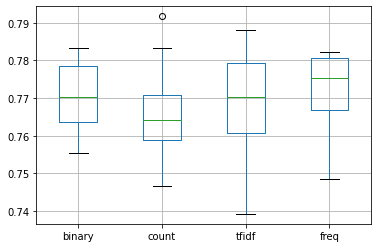

In [24]:
import seaborn as sns

results.boxplot()
plt.show()

## Summary

In [25]:
results

,binary,count,tfidf,freq
0,0.755389,0.771321,0.761012,0.778819
1,0.761949,0.759138,0.788191,0.776007
2,0.775797,0.769231,0.770169,0.782364
3,0.779550,0.758912,0.760788,0.766416
4,0.768293,0.761726,0.744841,0.781426
5,0.780488,0.783302,0.775797,0.768293
6,0.769231,0.791745,0.787054,0.774859
7,0.771107,0.746717,0.770169,0.762664
8,0.757036,0.766416,0.780488,0.782364
9,0.783302,0.746717,0.739212,0.748593


In [26]:
results.describe()

,binary,count,tfidf,freq
count,10.000000,10.000000,10.000000,10.000000
mean,0.770214,0.765522,0.767772,0.772181
std,0.009789,0.014369,0.016541,0.010822
min,0.755389,0.746717,0.739212,0.748593
25%,0.763535,0.758968,0.760844,0.766886
50%,0.770169,0.764071,0.770169,0.775433
75%,0.778612,0.770799,0.779315,0.780774
max,0.783302,0.791745,0.788191,0.782364


In [27]:
report = results
report = report.to_excel('BoW_MLP_MR_3.xlsx', sheet_name='model_3')

# Training and Testing the Model 2

## MLP Model 2

Now, we will build Multilayer Perceptron (MLP) models to classify encoded documents as either positive or negative.

As you might have expected, the models are simply feedforward network with fully connected layers called `Dense` in the `Keras` library.

Now, we will define our MLP neural network with very little trial and error so cannot be considered tuned for this problem. The configuration is as follows:
- First hidden layer with 100 neurons and Relu activation function
- Dropout layer with p = 0.5
- Output layer with Sigmoid activation function
- Optimizer: Adam (The best learning algorithm so far)
- Loss function: binary cross-entropy (suited for binary classification problem)

In [28]:
def train_mlp_2(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

## Train and Test the Model

In [29]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

def train_mlp_2(train_x, train_y, test_x, test_y, batch_size = 50, epochs = 20, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose, callbacks = [callbacks], validation_data=(test_x, test_y))
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

acc_list = []

# kfold.split() will return set indices for each split
for train, test in kfold.split(sentences):
    # Instantiate a vocab object
    vocab = Counter()
    
    train_x, test_x = [], []
    train_y, test_y = [], []
    
    for i in train:
        train_x.append(sentences[i])
        train_y.append(labels[i])
    
    for i in test:
        test_x.append(sentences[i])
        test_y.append(labels[i])
    
    # Turn the labels into a numpy array
    train_y = np.array(train_y)
    test_y = np.array(test_y)
    
    # Define a vocabulary for each fold
    vocab = add_doc_to_vocab(train_x, vocab)
    # print('The number of vocab: ', len(vocab))
    
    # Clean the sentences
    train_x = clean_docs(train_x, vocab)
    test_x = clean_docs(test_x, vocab)
    
    # Define the tokenizer
    tokenizer = create_tokenizer(train_x)
    
    # encode data using freq mode
    Xtrain = tokenizer.texts_to_matrix(train_x, mode='freq')
    Xtest = tokenizer.texts_to_matrix(test_x, mode='freq')
       
    # train the model
    model = train_mlp_2(Xtrain, train_y, Xtest, test_y)
    
    # evaluate the model
    loss, acc = model.evaluate(Xtest, test_y, verbose=0)
    print('Test Accuracy: {}'.format(acc*100))
    
    acc_list.append(acc)

acc_list = np.array(acc_list)
print()
print('The test ccuracy for each training:\n{}'.format(acc_list))
print('The mean of the test accuracy: ', acc_list.mean())

C:\Users\Diardano Raihan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass shuffle=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Epoch 1/20
192/192 - 6s - loss: 0.6756 - accuracy: 0.6330 - val_loss: 0.6413 - val_accuracy: 0.6542
Epoch 2/20
192/192 - 3s - loss: 0.5687 - accuracy: 0.7793 - val_loss: 0.5390 - val_accuracy: 0.7545
Epoch 3/20
192/192 - 3s - loss: 0.4527 - accuracy: 0.8302 - val_loss: 0.4950 - val_accuracy: 0.7601
Epoch 4/20
192/192 - 3s - loss: 0.3730 - accuracy: 0.8634 - val_loss: 0.4829 - val_accuracy: 0.7601
Epoch 5/20
192/192 - 3s - loss: 0.3194 - accuracy: 0.8840 - val_loss: 0.4886 - val_accuracy: 0.7638
Epoch 6/20
192/192 - 3s - loss: 0.2770 - accuracy: 0.9026 - val_loss: 0.5028 - val_accuracy: 0.7554
Epoch 7/20
192/192 - 3s - loss: 0.2437 - accuracy: 0.9145 - val_loss: 0.5202 - val_accuracy: 0.7610
Epoch 8/20
192/192 - 3s - loss: 0.2153 - accuracy: 0.9269 - val_loss: 0.5447 - val_accuracy: 0.7395
Epoch 9/20
192/192 - 3s - loss: 0.1891 - accuracy: 0.9389 - val_loss: 0.5705 - val_accuracy: 0.7507
Epoch 10/20
192/192 - 3s - loss: 0.1695 - accuracy: 0.9463 - val_loss: 0.5929 - val_accuracy: 0.7498

Epoch 3/20
192/192 - 3s - loss: 0.4557 - accuracy: 0.8216 - val_loss: 0.4911 - val_accuracy: 0.7824
Epoch 4/20
192/192 - 3s - loss: 0.3793 - accuracy: 0.8568 - val_loss: 0.4712 - val_accuracy: 0.7889
Epoch 5/20
192/192 - 3s - loss: 0.3233 - accuracy: 0.8813 - val_loss: 0.4670 - val_accuracy: 0.7889
Epoch 6/20
192/192 - 3s - loss: 0.2803 - accuracy: 0.9001 - val_loss: 0.4723 - val_accuracy: 0.7899
Epoch 7/20
192/192 - 3s - loss: 0.2471 - accuracy: 0.9132 - val_loss: 0.4829 - val_accuracy: 0.7814
Epoch 8/20
192/192 - 3s - loss: 0.2197 - accuracy: 0.9249 - val_loss: 0.4986 - val_accuracy: 0.7824
Epoch 9/20
192/192 - 3s - loss: 0.1932 - accuracy: 0.9348 - val_loss: 0.5168 - val_accuracy: 0.7730
Epoch 10/20
192/192 - 2s - loss: 0.1725 - accuracy: 0.9413 - val_loss: 0.5406 - val_accuracy: 0.7777
Epoch 11/20
192/192 - 3s - loss: 0.1538 - accuracy: 0.9520 - val_loss: 0.5608 - val_accuracy: 0.7674
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Test Accuracy:

## Comparing the Word Scoring Methods

When we use `text_to_matrix()` function, we are given 4 different methods for scoring words:
- `binary`: words are marked as 1 (present) or 0 (absent)
- `count`: words are counted based on their occurrence (integer)
- `tfidf`: words are scored  based on their frequency of occurrence in their own document, but also are being penalized if they are common across  all documents
- `freq`: wrods are scored based on their frequency of occurrence in their own document

In [30]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

def train_mlp_2(train_x, train_y, test_x, test_y, batch_size = 50, epochs = 20, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose, callbacks = [callbacks], validation_data=(test_x, test_y))
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

# Run Experiment of 4 different modes
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()

for mode in modes:
    print('mode: ', mode)
    acc_list = []
    
    # kfold.split() will return set indices for each split
    for train, test in kfold.split(sentences):
        # Instantiate a vocab object
        vocab = Counter()

        train_x, test_x = [], []
        train_y, test_y = [], []

        for i in train:
            train_x.append(sentences[i])
            train_y.append(labels[i])

        for i in test:
            test_x.append(sentences[i])
            test_y.append(labels[i])

        # Turn the labels into a numpy array
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        # Define a vocabulary for each fold
        vocab = add_doc_to_vocab(train_x, vocab)
        # print('The number of vocab: ', len(vocab))

        # Clean the sentences
        train_x = clean_docs(train_x, vocab)
        test_x = clean_docs(test_x, vocab)

        # encode data using freq mode
        Xtrain, Xtest = prepare_data(train_x, test_x, mode)

        # train the model
        model = train_mlp_2(Xtrain, train_y, Xtest, test_y, verbose=0)

        # evaluate the model
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print('Test Accuracy: {}'.format(acc*100))

        acc_list.append(acc)
    
    results[mode] = acc_list
    acc_list = np.array(acc_list)
    print('The test ccuracy for each training:\n{}'.format(acc_list))
    print('The mean of the test accuracy: ', acc_list.mean())
    print()

print(results)

mode:  binary
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 76.75726413726807
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 77.03842520713806
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 76.64164900779724
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 77.95497179031372
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 75.79737305641174
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 78.98686528205872
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Test Accuracy: 77.57973670959473
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Test Accuracy: 78.14258933067322
Restoring model weights from the end of the best e

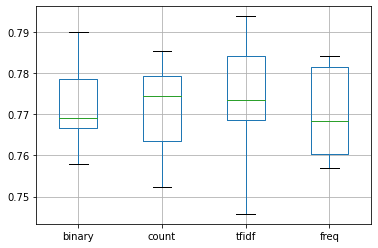

In [31]:
results.boxplot()
plt.show()

## Summary

In [32]:
results

,binary,count,tfidf,freq
0,0.767573,0.785380,0.763824,0.761949
1,0.770384,0.781631,0.793814,0.764761
2,0.766416,0.774859,0.771107,0.759850
3,0.779550,0.759850,0.768293,0.782364
4,0.757974,0.752345,0.775797,0.784240
5,0.789869,0.775797,0.775797,0.772045
6,0.775797,0.773921,0.769231,0.757036
7,0.781426,0.762664,0.745779,0.778612
8,0.767355,0.780488,0.787054,0.784240
9,0.766416,0.766416,0.791745,0.758912


In [33]:
results.describe()

,binary,count,tfidf,freq
count,10.000000,10.000000,10.000000,10.000000
mean,0.772276,0.771335,0.774244,0.770401
std,0.009319,0.010635,0.014327,0.011163
min,0.757974,0.752345,0.745779,0.757036
25%,0.766651,0.763602,0.768527,0.760375
50%,0.768978,0.774390,0.773452,0.768403
75%,0.778612,0.779315,0.784240,0.781426
max,0.789869,0.785380,0.793814,0.784240


In [34]:
report = results
report = report.to_excel('BoW_MLP_MR_2.xlsx', sheet_name='model_2')

# Training and Testing the Model 1

## MLP Model 1

Now, we will build Multilayer Perceptron (MLP) models to classify encoded documents as either positive or negative.

As you might have expected, the models are simply feedforward network with fully connected layers called `Dense` in the `Keras` library.

Now, we will define our MLP neural network with very little trial and error so cannot be considered tuned for this problem. The configuration is as follows:
- First hidden layer with 50 neurons and Relu activation function
- Dropout layer with p = 0.5
- Output layer with Sigmoid activation function
- Optimizer: Adam (The best learning algorithm so far)
- Loss function: binary cross-entropy (suited for binary classification problem)

In [35]:
def train_mlp_1(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=50, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

## Train and Test the Model

In [36]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

def train_mlp_1(train_x, train_y, test_x, test_y, batch_size = 50, epochs = 20, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=50, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose, callbacks = [callbacks], validation_data=(test_x, test_y))
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

acc_list = []

# kfold.split() will return set indices for each split
for train, test in kfold.split(sentences):
    # Instantiate a vocab object
    vocab = Counter()
    
    train_x, test_x = [], []
    train_y, test_y = [], []
    
    for i in train:
        train_x.append(sentences[i])
        train_y.append(labels[i])
    
    for i in test:
        test_x.append(sentences[i])
        test_y.append(labels[i])
    
    # Turn the labels into a numpy array
    train_y = np.array(train_y)
    test_y = np.array(test_y)
    
    # Define a vocabulary for each fold
    vocab = add_doc_to_vocab(train_x, vocab)
    # print('The number of vocab: ', len(vocab))
    
    # Clean the sentences
    train_x = clean_docs(train_x, vocab)
    test_x = clean_docs(test_x, vocab)
    
    # Define the tokenizer
    tokenizer = create_tokenizer(train_x)
    
    # encode data using freq mode
    Xtrain = tokenizer.texts_to_matrix(train_x, mode='freq')
    Xtest = tokenizer.texts_to_matrix(test_x, mode='freq')
       
    # train the model
    model = train_mlp_1(Xtrain, train_y, Xtest, test_y)
    
    # evaluate the model
    loss, acc = model.evaluate(Xtest, test_y, verbose=0)
    print('Test Accuracy: {}'.format(acc*100))
    
    acc_list.append(acc)

acc_list = np.array(acc_list)
print()
print('The test ccuracy for each training:\n{}'.format(acc_list))
print('The mean of the test accuracy: ', acc_list.mean())

C:\Users\Diardano Raihan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass shuffle=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Epoch 1/20
192/192 - 5s - loss: 0.6798 - accuracy: 0.6530 - val_loss: 0.6529 - val_accuracy: 0.7395
Epoch 2/20
192/192 - 4s - loss: 0.6051 - accuracy: 0.7661 - val_loss: 0.5743 - val_accuracy: 0.7610
Epoch 3/20
192/192 - 3s - loss: 0.5101 - accuracy: 0.8099 - val_loss: 0.5154 - val_accuracy: 0.7732
Epoch 4/20
192/192 - 3s - loss: 0.4365 - accuracy: 0.8393 - val_loss: 0.4825 - val_accuracy: 0.7788
Epoch 5/20
192/192 - 3s - loss: 0.3831 - accuracy: 0.8608 - val_loss: 0.4668 - val_accuracy: 0.7760
Epoch 6/20
192/192 - 3s - loss: 0.3396 - accuracy: 0.8779 - val_loss: 0.4606 - val_accuracy: 0.7816
Epoch 7/20
192/192 - 3s - loss: 0.3061 - accuracy: 0.8914 - val_loss: 0.4592 - val_accuracy: 0.7769
Epoch 8/20
192/192 - 3s - loss: 0.2761 - accuracy: 0.9068 - val_loss: 0.4631 - val_accuracy: 0.7826
Epoch 9/20
192/192 - 3s - loss: 0.2489 - accuracy: 0.9179 - val_loss: 0.4696 - val_accuracy: 0.7751
Epoch 10/20
192/192 - 3s - loss: 0.2288 - accuracy: 0.9232 - val_loss: 0.4773 - val_accuracy: 0.7732

Epoch 4/20
192/192 - 3s - loss: 0.4351 - accuracy: 0.8341 - val_loss: 0.4999 - val_accuracy: 0.7664
Epoch 5/20
192/192 - 3s - loss: 0.3777 - accuracy: 0.8608 - val_loss: 0.4872 - val_accuracy: 0.7692
Epoch 6/20
192/192 - 3s - loss: 0.3343 - accuracy: 0.8789 - val_loss: 0.4834 - val_accuracy: 0.7636
Epoch 7/20
192/192 - 3s - loss: 0.3047 - accuracy: 0.8942 - val_loss: 0.4824 - val_accuracy: 0.7711
Epoch 8/20
192/192 - 3s - loss: 0.2694 - accuracy: 0.9066 - val_loss: 0.4881 - val_accuracy: 0.7645
Epoch 9/20
192/192 - 3s - loss: 0.2458 - accuracy: 0.9167 - val_loss: 0.4958 - val_accuracy: 0.7711
Epoch 10/20
192/192 - 3s - loss: 0.2235 - accuracy: 0.9254 - val_loss: 0.5068 - val_accuracy: 0.7664
Epoch 11/20
192/192 - 2s - loss: 0.2049 - accuracy: 0.9350 - val_loss: 0.5206 - val_accuracy: 0.7655
Epoch 12/20
192/192 - 3s - loss: 0.1877 - accuracy: 0.9399 - val_loss: 0.5363 - val_accuracy: 0.7580
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Test Accuracy

## Comparing the Word Scoring Methods

When we use `text_to_matrix()` function, we are given 4 different methods for scoring words:
- `binary`: words are marked as 1 (present) or 0 (absent)
- `count`: words are counted based on their occurrence (integer)
- `tfidf`: words are scored  based on their frequency of occurrence in their own document, but also are being penalized if they are common across  all documents
- `freq`: wrods are scored based on their frequency of occurrence in their own document

In [37]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

def train_mlp_1(train_x, train_y, test_x, test_y, batch_size = 50, epochs = 20, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=50, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose, callbacks = [callbacks], validation_data=(test_x, test_y))
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

# Run Experiment of 4 different modes
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()

for mode in modes:
    print('mode: ', mode)
    acc_list = []
    
    # kfold.split() will return set indices for each split
    for train, test in kfold.split(sentences):
        # Instantiate a vocab object
        vocab = Counter()

        train_x, test_x = [], []
        train_y, test_y = [], []

        for i in train:
            train_x.append(sentences[i])
            train_y.append(labels[i])

        for i in test:
            test_x.append(sentences[i])
            test_y.append(labels[i])

        # Turn the labels into a numpy array
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        # Define a vocabulary for each fold
        vocab = add_doc_to_vocab(train_x, vocab)
        # print('The number of vocab: ', len(vocab))

        # Clean the sentences
        train_x = clean_docs(train_x, vocab)
        test_x = clean_docs(test_x, vocab)

        # encode data using freq mode
        Xtrain, Xtest = prepare_data(train_x, test_x, mode)

        # train the model
        model = train_mlp_1(Xtrain, train_y, Xtest, test_y, verbose=0)

        # evaluate the model
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print('Test Accuracy: {}'.format(acc*100))

        acc_list.append(acc)
    
    results[mode] = acc_list
    acc_list = np.array(acc_list)
    print('The test ccuracy for each training:\n{}'.format(acc_list))
    print('The mean of the test accuracy: ', acc_list.mean())
    print()

print(results)

mode:  binary
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 78.35051417350769
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping
Test Accuracy: 78.0693531036377
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Test Accuracy: 80.01875877380371
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 74.95309710502625
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Test Accuracy: 77.48593091964722
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Test Accuracy: 76.54784321784973
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Test Accuracy: 76.92307829856873
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Test Accuracy: 77.67354846000671
Restoring model weights from the end of the best ep

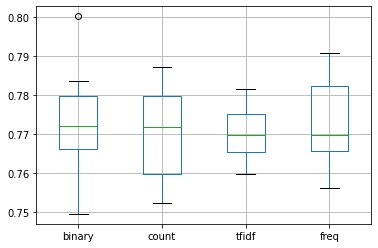

In [38]:
results.boxplot()
plt.show()

## Summary

In [39]:
results

,binary,count,tfidf,freq
0,0.783505,0.771321,0.761012,0.765698
1,0.780694,0.783505,0.764761,0.769447
2,0.800188,0.757036,0.772983,0.756098
3,0.749531,0.772045,0.759850,0.760788
4,0.774859,0.757974,0.779550,0.790807
5,0.765478,0.777674,0.770169,0.786116
6,0.769231,0.765478,0.769231,0.770169
7,0.776735,0.752345,0.781426,0.771107
8,0.768293,0.787054,0.775797,0.765478
9,0.761726,0.780488,0.767355,0.789869


In [40]:
results.describe()

,binary,count,tfidf,freq
count,10.000000,10.000000,10.000000,10.000000
mean,0.773024,0.770492,0.770213,0.772558
std,0.013731,0.011974,0.007323,0.012205
min,0.749531,0.752345,0.759850,0.756098
25%,0.766182,0.759850,0.765409,0.765533
50%,0.772045,0.771683,0.769700,0.769808
75%,0.779704,0.779784,0.775094,0.782364
max,0.800188,0.787054,0.781426,0.790807


In [41]:
report = results
report = report.to_excel('BoW_MLP_MR_1.xlsx', sheet_name='model_1')